# Problem 4: Bear Multi-Label Classication

In [3]:
from fastbook import *

### Load images

- NOTE: For convenience, the images searched using Bing API were uploaded to Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = Path('./drive/MyDrive/ml-data/bears')
other_path = Path('./drive/MyDrive/ml-data/no-bears')

In [6]:
path.ls()

(#3) [Path('drive/MyDrive/ml-data/bears/grizzly'),Path('drive/MyDrive/ml-data/bears/black'),Path('drive/MyDrive/ml-data/bears/teddy')]

In [7]:
other_path.ls()

(#3) [Path('drive/MyDrive/ml-data/no-bears/car'),Path('drive/MyDrive/ml-data/no-bears/dog'),Path('drive/MyDrive/ml-data/no-bears/building')]

### Standard model

In [ ]:
get_image_files(path)

(#416) [Path('drive/MyDrive/ml-data/bears/grizzly/00000000.jpg'),Path('drive/MyDrive/ml-data/bears/grizzly/00000002.jpg'),Path('drive/MyDrive/ml-data/bears/grizzly/00000004.jpg'),Path('drive/MyDrive/ml-data/bears/grizzly/00000003.jpg'),Path('drive/MyDrive/ml-data/bears/grizzly/00000012.jpg'),Path('drive/MyDrive/ml-data/bears/grizzly/00000007.jpg'),Path('drive/MyDrive/ml-data/bears/grizzly/00000011.jpg'),Path('drive/MyDrive/ml-data/bears/grizzly/00000013.jpg'),Path('drive/MyDrive/ml-data/bears/grizzly/00000010.jpg'),Path('drive/MyDrive/ml-data/bears/grizzly/00000009.jpg')...]

In [ ]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=23),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = bears.dataloaders(path)

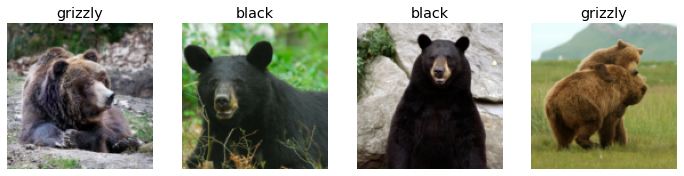

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

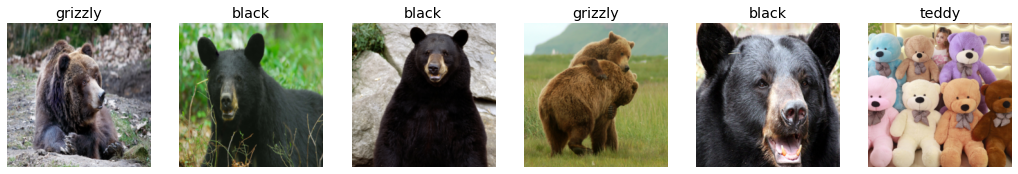

In [ ]:
dls.valid.show_batch(max_n=6, nrows=1)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.373163,0.072643,0.012048,01:52


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.183823,0.036528,0.012048,00:23
1,0.141846,0.014712,0.000000,00:23
2,0.104811,0.011240,0.000000,00:24
3,0.086676,0.013184,0.000000,00:23


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


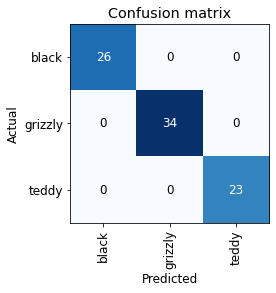

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Test the model for images that do not contain bears

In [8]:
import random
from PIL import Image

In [9]:
def pick_random_bear(cls):
  images = (path / cls).ls()
  idx = random.randint(0, len(images) - 1)
  return str(images[idx])

In [10]:
def pick_random_no_bear(cls):
  images = (other_path / cls).ls()
  idx = random.randint(0, len(images) - 1)
  return str(images[idx])

### Show probabilities

In [ ]:
rand_dog = pick_random_no_bear('dog')

In [ ]:
pred, pred_idx, probs = learn.predict(rand_dog)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: teddy; Probability: 0.7904')

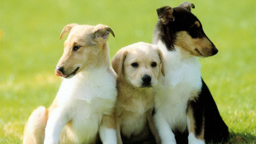

In [ ]:
rand_dog_img = Image.open(rand_dog)
rand_dog_img.to_thumb(256)

### Multi-label Classification

In [11]:
import pandas as pd

In [11]:
def create_df():
  rows = []

  for child_path in path.ls():
    label = child_path.name
    for img_path in child_path.ls():
      rows.append([img_path, label])

  for child_path in other_path.ls():
    for img_path in child_path.ls():
      rows.append([img_path, 'none'])

  random.shuffle(rows)
  return pd.DataFrame(rows, columns=['path', 'labels'])

In [12]:
df = create_df()

In [13]:
df.head()

,path,labels
0,drive/MyDrive/ml-data/bears/grizzly/00000127.jpg,grizzly
1,drive/MyDrive/ml-data/bears/teddy/00000015.jpg,teddy
2,drive/MyDrive/ml-data/no-bears/car/00000033.jpg,none
3,drive/MyDrive/ml-data/bears/black/00000085.jpg,black
4,drive/MyDrive/ml-data/bears/teddy/00000141.jpg?c=2&imbypass=on,teddy


In [14]:
def get_x(r): return r['path']
def get_y(r): return r['labels'].split(' ') if r['labels'] != 'none' else []

In [15]:
bears = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock), 
    splitter=RandomSplitter(valid_pct=0.2, seed=23),
    get_x=get_x,
    get_y=get_y,
    item_tfms=RandomResizedCrop(224, min_scale=0.5))
dls = bears.dataloaders(df)

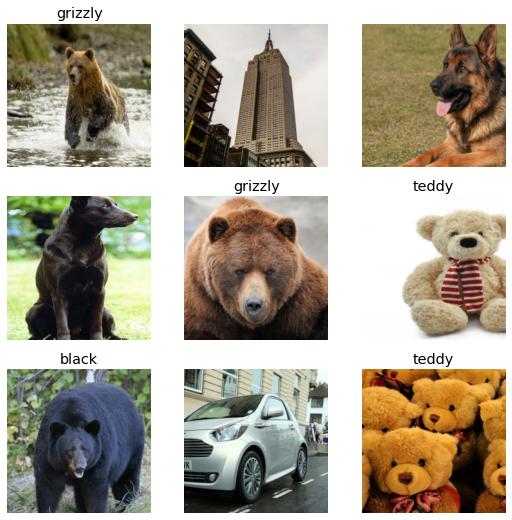

In [16]:
dls.show_batch(nrows=3, ncols=3)

In [17]:
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.8))
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.785169,0.481987,0.916190,02:51


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.365058,0.268312,0.973333,00:36
1,0.284079,0.157502,0.977143,00:36
2,0.212428,0.120877,0.980952,00:37
3,0.170792,0.102440,0.982857,00:37


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


### Interpret multi-label model prediction results

In [28]:
rand_car = pick_random_no_bear('car')

In [29]:
learn.predict(rand_car)

((#0) [], tensor([False, False, False]), tensor([0.0637, 0.0354, 0.0207]))

In [31]:
rand_dog = pick_random_no_bear('dog')
learn.predict(rand_dog)

((#0) [], tensor([False, False, False]), tensor([0.0432, 0.0370, 0.0079]))

In [33]:
rand_grizzly = pick_random_bear('grizzly')
learn.predict(rand_grizzly)

((#1) ['grizzly'],
 tensor([False,  True, False]),
 tensor([3.1993e-02, 1.0000e+00, 6.2103e-04]))

In [34]:
from sklearn.metrics import confusion_matrix

In [54]:
learn.predict(dls.valid_ds[4][0])

((#1) ['grizzly'],
 tensor([False,  True, False]),
 tensor([3.9235e-04, 1.0000e+00, 1.6595e-03]))

In [56]:
dls.valid_ds[4]

(PILImage mode=RGB size=1910x1000, TensorMultiCategory([0., 1., 0.]))

In [91]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

In [87]:
labels = ['black', 'grizzly', 'teddy', 'other']

In [58]:
def find_index(t):
    for i, e in enumerate(t):
      if e:
        return i
    return len(t)

In [83]:
def get_pred_stats():
  y_true = []
  y_pred = []
  for item in dls.valid_ds:
    _, pred, _ = learn.predict(item[0])
    true_idx = find_index(item[1])
    pred_idx = find_index(pred)
    y_true.append(true_idx)
    y_pred.append(pred_idx)
  return y_true, y_pred

In [84]:
y_true, y_pred = get_pred_stats()

In [93]:
num_incorrect = sum([0 if item[0] != item[1] else 1 for item in zip(y_true, y_pred)])
print(f'Number of incorrect predictions: {num_incorrect}')

Number of incorrect predictions: 169


In [94]:
conf_m = confusion_matrix(y_true, y_pred, range(4))
conf_m

array([[34,  1,  0,  0],
       [ 1, 28,  0,  0],
       [ 0,  0, 22,  0],
       [ 3,  1,  0, 85]])

In [98]:
df_conf_m = pd.DataFrame(conf_m, labels, labels)

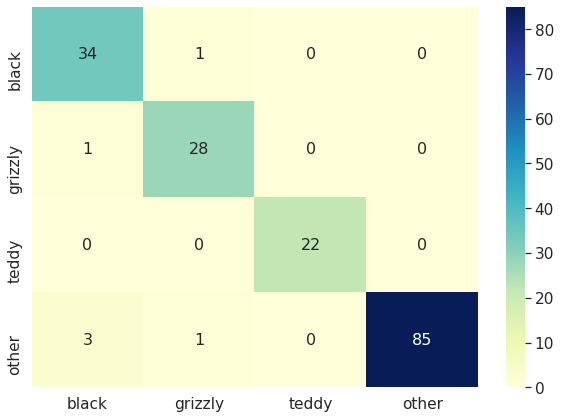

In [100]:
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_conf_m, annot=True, annot_kws={"size": 16}, cmap='YlGnBu')
plt.show()